Data Preparation

In [ ]:
import pandas as pd

# Load CSV files
air_quality = pd.read_csv("data/air_quality_data.csv")
forecast = pd.read_csv("data/forecast_data.csv")
pollution = pd.read_csv("data/pollution_data.csv")
noaa_weather = pd.read_csv("data/noaa_weather_data.csv")

# Convert timestamps to datetime format (floor to minute-level precision for uniformity)
air_quality['timestamp'] = pd.to_datetime(air_quality['timestamp']).dt.floor('min')
forecast['timestamp'] = pd.to_datetime(forecast['timestamp']).dt.floor('min')
pollution['timestamp'] = pd.to_datetime(pollution['timestamp']).dt.floor('min')
noaa_weather['date'] = pd.to_datetime(noaa_weather['date']).dt.floor('min')

# Extract relevant weather data from the NOAA dataset and pivot it
weather_data = noaa_weather[['date', 'datatype', 'value']]
weather_data = weather_data.pivot_table(index='date', columns='datatype', values='value', aggfunc='first')

# Rename columns for consistency
weather_data.columns = weather_data.columns.str.strip()  # Remove any leading/trailing spaces

# Merge air quality and forecast data on timestamp
merged_data = pd.merge(air_quality, forecast, on='timestamp', how='outer')

# Merge with pollution data on timestamp
merged_data = pd.merge(merged_data, pollution, on='timestamp', how='outer')

# Merge with the weather data on timestamp (date column converted to timestamp)
merged_data = pd.merge(merged_data, weather_data, left_on='timestamp', right_index=True, how='outer')

# Handle missing values (fill forward)
merged_data.fillna(method='ffill', inplace=True)

# Aggregate the data by timestamp (in case of duplicate rows by timestamp)
merged_data = merged_data.groupby('timestamp').agg({
    'aqi_us': 'mean', 
    'aqi_cn': 'mean',
    'main_pollutant_us': 'first',  # Assuming main pollutant remains the same for each minute
    'main_pollutant_cn': 'first',
    'temperature': 'mean',
    'humidity': 'mean',
    'weather': 'first',  # Assuming weather condition remains constant for each minute
    'co': 'mean',
    'no2': 'mean',
    'o3': 'mean',
    'pm2_5': 'mean',
    'pm10': 'mean',
    'PRCP': 'mean',
    'TAVG': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean'
}).reset_index()

# Save the merged and processed data to a new CSV file
merged_data.to_csv("final_merged_data.csv", index=False)
print("Data preprocessing completed. Saved as final_merged_data.csv.")


Data preprocessing completed. Saved as final_merged_data.csv.


C:\Users\faiza\AppData\Local\Temp\ipykernel_7100\2358207740.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [15]:
import pandas as pd

# Load the processed CSV
data = pd.read_csv("final_merged_data.csv")

# Drop unnecessary columns (adjusted to the columns in the final merged dataset)
data.drop(columns=["datatype", "station", "attributes"], inplace=True, errors='ignore')

# Handle missing values (forward-fill and interpolation)
data["aqi_us"] = data["aqi_us"].fillna(method="ffill").interpolate()
data["aqi_cn"] = data["aqi_cn"].fillna(method="ffill").interpolate()
data["temperature"] = data["temperature"].fillna(method="ffill").interpolate()
data["humidity"] = data["humidity"].fillna(method="ffill").interpolate()

# Drop rows where AQI values are still missing
data.dropna(subset=["aqi_us", "aqi_cn"], inplace=True)

# Encode categorical columns
data["weather"] = data["weather"].astype("category").cat.codes
data["main_pollutant_us"] = data["main_pollutant_us"].astype("category").cat.codes
data["main_pollutant_cn"] = data["main_pollutant_cn"].astype("category").cat.codes

# Add temporal features (timestamp column should already be in the dataset)
data["hour"] = pd.to_datetime(data["timestamp"]).dt.hour
data["day"] = pd.to_datetime(data["timestamp"]).dt.day
data["month"] = pd.to_datetime(data["timestamp"]).dt.month

# Save the refined dataset
data.to_csv("final_data.csv", index=False)
print("Final dataset saved as final_data.csv.")


Final dataset saved as final_data.csv.


C:\Users\faiza\AppData\Local\Temp\ipykernel_7100\1155113383.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["aqi_us"] = data["aqi_us"].fillna(method="ffill").interpolate()
C:\Users\faiza\AppData\Local\Temp\ipykernel_7100\1155113383.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["aqi_cn"] = data["aqi_cn"].fillna(method="ffill").interpolate()
C:\Users\faiza\AppData\Local\Temp\ipykernel_7100\1155113383.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["temperature"] = data["temperature"].fillna(method="ffill").interpolate()
C:\Users\faiza\AppData\Local\Temp\ipykernel_7100\1155113383.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() o

Final Data Mapping

In [18]:
import pandas as pd

# Load the processed CSV (final merged data)
data = pd.read_csv("final_merged_data.csv")

# Drop unnecessary columns (adjusted to the final merged dataset)
data.drop(columns=["datatype", "station", "attributes"], inplace=True, errors='ignore')

# Handle missing values (forward-fill and interpolation)
data["aqi_us"] = data["aqi_us"].ffill().interpolate()
data["aqi_cn"] = data["aqi_cn"].ffill().interpolate()
data["temperature"] = data["temperature"].ffill().interpolate()
data["humidity"] = data["humidity"].ffill().interpolate()

# Drop rows where AQI values are still missing
data.dropna(subset=["aqi_us", "aqi_cn"], inplace=True)

# Encode categorical columns and save mappings
data["main_pollutant_us"] = data["main_pollutant_us"].astype("category")
data["main_pollutant_cn"] = data["main_pollutant_cn"].astype("category")

# Factorize and save mappings
us_mapping = data["main_pollutant_us"].cat.categories
cn_mapping = data["main_pollutant_cn"].cat.categories

# Save the mappings for reference
us_mapping_df = pd.Series(range(len(us_mapping)), index=us_mapping, name="Main Pollutant US")
us_mapping_df.to_csv("main_pollutant_us_mapping.csv", header=True, index_label="Code")

cn_mapping_df = pd.Series(range(len(cn_mapping)), index=cn_mapping, name="Main Pollutant CN")
cn_mapping_df.to_csv("main_pollutant_cn_mapping.csv", header=True, index_label="Code")

# Encode weather
data["weather"] = data["weather"].astype("category").cat.codes

# Add temporal features
data["hour"] = pd.to_datetime(data["timestamp"]).dt.hour
data["day"] = pd.to_datetime(data["timestamp"]).dt.day
data["month"] = pd.to_datetime(data["timestamp"]).dt.month

# Save the refined dataset
data.to_csv("final_data.csv", index=False)
print("Final dataset saved as final_data.csv.")
print("Mapping saved as 'main_pollutant_us_mapping.csv' and 'main_pollutant_cn_mapping.csv'")


Final dataset saved as final_data.csv.
Mapping saved as 'main_pollutant_us_mapping.csv' and 'main_pollutant_cn_mapping.csv'


Preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the final data
data = pd.read_csv("final_data.csv")

# Define features and target
features = ["temperature", "humidity", "weather", "hour", "day", "month", 
            "co", "no2", "o3", "pm2_5", "pm10", "PRCP", "TAVG", "TMAX", "TMIN"]
target = "aqi_us"  # You can also use "aqi_cn" as the target

X = data[features]
y = data[target]

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preparation completed.")


LSTM Model Development

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.tensorflow
from tensorflow.keras.callbacks import EarlyStopping

# Load the final dataset
data = pd.read_csv("final_data.csv")

# Check for NaN or infinite values in the data
if data.isnull().values.any() or np.any(np.isnan(data)) or np.any(np.isinf(data)):
    print("Warning: The data contains NaN or infinite values. Handling them...")
    # Fill NaNs only in numeric columns with the mean of each column
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

    # Replace infinite values with NaN and fill again in numeric columns
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Define features and target
features = ["temperature", "humidity", "weather", "hour", "day", "month", 
            "co", "no2", "o3", "pm2_5", "pm10", "PRCP", "TAVG", "TMAX", "TMIN"]
target = "aqi_us"

X = data[features]
y = data[target]

# Check for NaN or infinite values in features and target
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale features and target
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale target variable
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Check for NaNs or infinities in scaled data
X_train_scaled = np.clip(X_train_scaled, -1, 1) if np.any(np.isnan(X_train_scaled)) or np.any(np.isinf(X_train_scaled)) else X_train_scaled
X_test_scaled = np.clip(X_test_scaled, -1, 1) if np.any(np.isnan(X_test_scaled)) or np.any(np.isinf(X_test_scaled)) else X_test_scaled

# Create sequences for LSTM
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(target[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 5
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X_train_seq.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
model.compile(optimizer=optimizer, loss="mse")

# Early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train model with MLflow logging
mlflow.tensorflow.autolog()
with mlflow.start_run():
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50, batch_size=16, validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1  # Display progress during training
    )

    # Make predictions
    predictions = model.predict(X_test_seq)

    # Inverse transform predictions and test values
    predictions = target_scaler.inverse_transform(predictions)
    y_test_seq = target_scaler.inverse_transform(y_test_seq)

    # Evaluate metrics
    mse = mean_squared_error(y_test_seq, predictions)
    mae = mean_absolute_error(y_test_seq, predictions)
    r2 = r2_score(y_test_seq, predictions)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R² Score: {r2}")

    # Log metrics in MLflow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Save the trained model
    model.save("pollution_trend_lstm.keras")
    mlflow.log_artifact("pollution_trend_lstm.keras")
    print("Model training logged in MLflow.")

# Save predictions
predictions_df = pd.DataFrame({"Actual": y_test_seq.flatten(), "Predicted": predictions.flatten()})
predictions_df.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv.")


C:\Users\faiza\AppData\Local\Temp\ipykernel_7100\1898019329.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Epoch 1/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3398

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step - loss: 0.3857 - val_loss: 0.0305
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2624

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4022 - val_loss: 0.0259
Epoch 3/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2953

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.3757 - val_loss: 0.0217
Epoch 4/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3760

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3313 - val_loss: 0.0179
Epoch 5/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3050

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.3474 - val_loss: 0.0145
Epoch 6/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2980

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.3389 - val_loss: 0.0115
Epoch 7/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2775

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.3353 - val_loss: 0.0089
Epoch 8/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2817

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.3233 - val_loss: 0.0066
Epoch 9/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.3172

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.2988 - val_loss: 0.0047
Epoch 10/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3811

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2648 - val_loss: 0.0031
Epoch 11/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3118

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2830 - val_loss: 0.0019
Epoch 12/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2507

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2979 - val_loss: 9.6611e-04
Epoch 13/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2511

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.2904 - val_loss: 3.5237e-04
Epoch 14/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2972

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.2644 - val_loss: 4.4223e-05
Epoch 15/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2414

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2791 - val_loss: 2.7989e-05
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2518 - val_loss: 2.8761e-04
Epoch 17/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2706 - val_loss: 7.9725e-04
Epoch 18/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2432 - val_loss: 0.0015
Epoch 19/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.2617 - val_loss: 0.0025
Epoch 20/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.2605 - val_loss: 0.0036
Epoch 21/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2168 - val_loss: 0.0048
Epoch 22/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.2490 - val_loss: 0.0062
Epoch 23/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2459 - val_loss: 0.0078
Epoch 24/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2397 - val_loss: 0.0095
Epoch 25/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2043 - val_loss: 0.0113


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Mean Squared Error: 0.020180769788563053
Mean Absolute Error: 0.13799285888670454
R² Score: 0.0
Model training logged in MLflow.
Predictions saved to predictions.csv.


Best Model Hyperparameter Tuning Model Evaluation

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.tensorflow
from tensorflow.keras.callbacks import EarlyStopping
import itertools

# Load the final dataset
data = pd.read_csv("final_data.csv")

# Check for NaN or infinite values in the data
if data.isnull().values.any() or np.any(np.isnan(data)) or np.any(np.isinf(data)):
    print("Warning: The data contains NaN or infinite values. Handling them...")
    # Fill NaNs only in numeric columns with the mean of each column
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

    # Replace infinite values with NaN and fill again in numeric columns
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Define features and target
features = ["temperature", "humidity", "weather", "hour", "day", "month", 
            "co", "no2", "o3", "pm2_5", "pm10", "PRCP", "TAVG", "TMAX", "TMIN"]
target = "aqi_us"

X = data[features]
y = data[target]

# Check for NaN or infinite values in features and target
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale features and target
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale target variable
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Check for NaNs or infinities in scaled data
X_train_scaled = np.clip(X_train_scaled, -1, 1) if np.any(np.isnan(X_train_scaled)) or np.any(np.isinf(X_train_scaled)) else X_train_scaled
X_test_scaled = np.clip(X_test_scaled, -1, 1) if np.any(np.isnan(X_test_scaled)) or np.any(np.isinf(X_test_scaled)) else X_test_scaled

# Create sequences for LSTM
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(target[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 5
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

# Define a function to build the model with Dropout and additional hyperparameters
def build_model(units, learning_rate, dropout_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(units),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model

# Hyperparameter grid with additional dropout rate
param_grid = {
    "units": [50, 100, 150],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32],
    "dropout_rate": [0.2, 0.3]  # Adding dropout rate for regularization
}

# Grid Search
best_model = None
best_score = float("inf")
best_params = None
best_model_name = ""

# Iterate over parameter combinations
for units, learning_rate, batch_size, dropout_rate in itertools.product(*param_grid.values()):
    print(f"Training with units={units}, learning_rate={learning_rate}, batch_size={batch_size}, dropout_rate={dropout_rate}")
    
    # Build and train the model
    model = build_model(units, learning_rate, dropout_rate)
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    
    # Log training in MLflow
    mlflow.tensorflow.autolog()
    with mlflow.start_run():
        history = model.fit(
            X_train_seq, y_train_seq,
            epochs=50,
            batch_size=batch_size,
            validation_split=0.1,
            callbacks=[early_stopping],
            verbose=0  # Suppress detailed logs
        )
        
        # Make predictions
        predictions = model.predict(X_test_seq)
        predictions = target_scaler.inverse_transform(predictions)
        y_test_seq_rescaled = target_scaler.inverse_transform(y_test_seq)

        # Evaluate metrics
        mse = mean_squared_error(y_test_seq_rescaled, predictions)
        mae = mean_absolute_error(y_test_seq_rescaled, predictions)
        r2 = r2_score(y_test_seq_rescaled, predictions)
        
        print(f"MSE: {mse}, MAE: {mae}, R²: {r2}")

        # Log metrics in MLflow
        mlflow.log_param("units", units)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("dropout_rate", dropout_rate)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        
        # Save model artifact
        model_name = f"pollution_trend_lstm_{units}_{learning_rate}_{batch_size}_{dropout_rate}.keras"
        model.save(model_name)
        mlflow.log_artifact(model_name)
        
        # Track the best model
        if mse < best_score:
            best_model = model
            best_score = mse
            best_params = (units, learning_rate, batch_size, dropout_rate)
            best_model_name = model_name

print(f"Best Model Parameters: units={best_params[0]}, learning_rate={best_params[1]}, batch_size={best_params[2]}, dropout_rate={best_params[3]}")
print(f"Best MSE: {best_score}")
print(f"Best Model Saved as: {best_model_name}")

# Save predictions from the best model
best_predictions = best_model.predict(X_test_seq)
best_predictions = target_scaler.inverse_transform(best_predictions)
predictions_df = pd.DataFrame({
    "Actual": target_scaler.inverse_transform(y_test_seq).flatten(),
    "Predicted": best_predictions.flatten()
})
predictions_df.to_csv("best_predictions.csv", index=False)
print("Best predictions saved to best_predictions.csv.")


Training with units=50, learning_rate=0.001, batch_size=16, dropout_rate=0.2


C:\Users\faiza\AppData\Local\Temp\ipykernel_7100\2566352704.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
MSE: 0.027877969376276995, MAE: 0.14535268147785985, R²: 0.0
Training with units=50, learning_rate=0.001, batch_size=16, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
MSE: 3.898400755540884, MAE: 1.7284215291341003, R²: 0.0
Training with units=50, learning_rate=0.001, batch_size=32, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
MSE: 2.368836805166168, MAE: 1.5239741007486838, R²: 0.0
Training with units=50, learning_rate=0.001, batch_size=32, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
MSE: 0.9644095336746538, MAE: 0.7867406209309848, R²: 0.0
Training with units=50, learning_rate=0.0005, batch_size=16, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
MSE: 0.09722606661186639, MAE: 0.28733571370443184, R²: 0.0
Training with units=50, learning_rate=0.0005, batch_size=16, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
MSE: 0.28207145945633305, MAE: 0.4882609049479025, R²: 0.0
Training with units=50, learning_rate=0.0005, batch_size=32, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
MSE: 0.3548540120051986, MAE: 0.46443939208984847, R²: 0.0
Training with units=50, learning_rate=0.0005, batch_size=32, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
MSE: 5.847657144651765, MAE: 2.1013539632161504, R²: 0.0
Training with units=100, learning_rate=0.001, batch_size=16, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
MSE: 4.599778339111512, MAE: 1.581044514973944, R²: 0.0
Training with units=100, learning_rate=0.001, batch_size=16, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
MSE: 0.43489208805839175, MAE: 0.4527740478515483, R²: 0.0
Training with units=100, learning_rate=0.001, batch_size=32, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
MSE: 1.4036375713573344, MAE: 0.9925562540690057, R²: 0.0
Training with units=100, learning_rate=0.001, batch_size=32, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
MSE: 19.464060532355898, MAE: 3.2908833821614536, R²: 0.0
Training with units=100, learning_rate=0.0005, batch_size=16, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
MSE: 22.09440138503356, MAE: 3.5657526652018183, R²: 0.0
Training with units=100, learning_rate=0.0005, batch_size=16, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
MSE: 1.9021536308185614, MAE: 1.1600392659505256, R²: 0.0
Training with units=100, learning_rate=0.0005, batch_size=32, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
MSE: 14.857801940136973, MAE: 3.133168538411463, R²: 0.0
Training with units=100, learning_rate=0.0005, batch_size=32, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MSE: 0.7940950221770313, MAE: 0.6408233642578173, R²: 0.0
Training with units=150, learning_rate=0.001, batch_size=16, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
MSE: 11.263779946932656, MAE: 2.454536437988267, R²: 0.0
Training with units=150, learning_rate=0.001, batch_size=16, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
MSE: 0.24031820035696097, MAE: 0.46078999837241, R²: 0.0
Training with units=150, learning_rate=0.001, batch_size=32, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
MSE: 17.302248765617367, MAE: 3.1411870320637973, R²: 0.0
Training with units=150, learning_rate=0.001, batch_size=32, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
MSE: 0.029750545547963716, MAE: 0.16766357421874525, R²: 0.0
Training with units=150, learning_rate=0.0005, batch_size=16, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
MSE: 10.177792403846912, MAE: 2.3858439127604023, R²: 0.0
Training with units=150, learning_rate=0.0005, batch_size=16, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
MSE: 0.13763884288104658, MAE: 0.3615214029948059, R²: 0.0
Training with units=150, learning_rate=0.0005, batch_size=32, dropout_rate=0.2


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
MSE: 0.6500234086997938, MAE: 0.6895853678385464, R²: 0.0
Training with units=150, learning_rate=0.0005, batch_size=32, dropout_rate=0.3


C:\Users\faiza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
MSE: 7.274981864669876, MAE: 2.262855529785161, R²: 0.0
Best Model Parameters: units=50, learning_rate=0.001, batch_size=16, dropout_rate=0.2
Best MSE: 0.027877969376276995
Best Model Saved as: pollution_trend_lstm_50_0.001_16_0.2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Best predictions saved to best_predictions.csv.


Arima Model HyperTunning

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import pickle
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from itertools import product

# Load the final dataset
data = pd.read_csv("final_data.csv")

# Check for NaN or infinite values in the data
if data.isnull().values.any() or np.any(np.isnan(data)) or np.any(np.isinf(data)):
    print("Warning: The data contains NaN or infinite values. Handling them...")
    # Fill NaNs only in numeric columns with the mean of each column
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

    # Replace infinite values with NaN and fill again in numeric columns
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Define features and target
features = ["temperature", "humidity", "weather", "hour", "day", "month", 
            "co", "no2", "o3", "pm2_5", "pm10", "PRCP", "TAVG", "TMAX", "TMIN"]
target = "aqi_us"

X = data[features].copy()  # Explicitly create a copy to avoid SettingWithCopyWarning
y = data[target]

# Check for NaN or infinite values in features and target
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale target variable
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Define the parameter grid for ARIMA (p, d, q)
p_values = [1, 2, 3]
d_values = [0, 1]
q_values = [1, 2]

param_grid = product(p_values, d_values, q_values)

best_model = None
best_score = float("inf")
best_params = None
best_model_name = ""

# Grid Search for ARIMA
for p, d, q in param_grid:
    print(f"Training ARIMA model with p={p}, d={d}, q={q}")
    
    # Ensure any previous MLflow run is ended before starting a new one
    mlflow.end_run()  # Explicitly end any active MLflow run
    
    # Start a new MLflow run for each model
    with mlflow.start_run():
        try:
            # Build and train ARIMA model
            model = ARIMA(y_train_scaled.flatten(), order=(p, d, q))
            model_fit = model.fit()

            # Make predictions
            predictions = model_fit.forecast(steps=len(y_test_scaled))
            predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
            y_test_rescaled = scaler.inverse_transform(y_test_scaled)

            # Evaluate metrics
            mse = mean_squared_error(y_test_rescaled, predictions)
            mae = mean_absolute_error(y_test_rescaled, predictions)
            r2 = r2_score(y_test_rescaled, predictions)
            
            print(f"MSE: {mse}, MAE: {mae}, R²: {r2}")
            
            # Log metrics in MLflow
            mlflow.log_param("p", p)
            mlflow.log_param("d", d)
            mlflow.log_param("q", q)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("r2", r2)
            
            # Save model artifact using pickle
            model_name = f"pollution_trend_arima_{p}_{d}_{q}.pkl"
            with open(model_name, 'wb') as model_file:
                pickle.dump(model_fit, model_file)
            
            # Track the best model
            if mse < best_score:
                best_model = model_fit
                best_score = mse
                best_params = (p, d, q)
                best_model_name = model_name
                
        except Exception as e:
            print(f"Error training ARIMA model with p={p}, d={d}, q={q}: {e}")
        
        # Ensure MLflow run is properly ended
        mlflow.end_run()

print(f"Best Model Parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}")
print(f"Best MSE: {best_score}")
print(f"Best Model Saved as: {best_model_name}")

# Save predictions from the best model
best_predictions = best_model.forecast(steps=len(y_test_scaled))
best_predictions = scaler.inverse_transform(best_predictions.reshape(-1, 1))
predictions_df = pd.DataFrame({
    "Actual": scaler.inverse_transform(y_test_scaled).flatten(),
    "Predicted": best_predictions.flatten()
})
predictions_df.to_csv("best_arima_predictions.csv", index=False)
print("Best ARIMA predictions saved to best_arima_predictions.csv.")


Training ARIMA model with p=1, d=0, q=1
MSE: 2.2260289062726546, MAE: 1.3476295242763996, R²: 0.0
Training ARIMA model with p=1, d=0, q=2
MSE: 5.173456410575153, MAE: 2.0210433045009157, R²: 0.0
Training ARIMA model with p=1, d=1, q=1
MSE: 1.862176179791581e-05, MAE: 0.00409615157277976, R²: 0.0
Training ARIMA model with p=1, d=1, q=2
MSE: 0.00036966184874826164, MAE: 0.018800096390975796, R²: 0.0
Training ARIMA model with p=2, d=0, q=1


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MSE: 1.7185091356840347, MAE: 1.1849283729975149, R²: 0.0
Training ARIMA model with p=2, d=0, q=2
MSE: 4.592062907226821, MAE: 1.901135318484208, R²: 0.0
Training ARIMA model with p=2, d=1, q=1
MSE: 1.1963749219721523e-18, MAE: 1.0758309798575283e-09, R²: 0.0
Training ARIMA model with p=2, d=1, q=2
MSE: 0.037350954165681655, MAE: 0.1902352332098154, R²: 0.0
Training ARIMA model with p=3, d=0, q=1
MSE: 8.6875565204021, MAE: 2.590573793722175, R²: 0.0
Training ARIMA model with p=3, d=0, q=2


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 3.9356689152488906, MAE: 1.8051767464829762, R²: 0.0
Training ARIMA model with p=3, d=1, q=1
MSE: 7.591341931270552e-05, MAE: 0.008267554133620791, R²: 0.0
Training ARIMA model with p=3, d=1, q=2
MSE: 0.020969282314721623, MAE: 0.13848624736228388, R²: 0.0
Best Model Parameters: p=2, d=1, q=1
Best MSE: 1.1963749219721523e-18
Best Model Saved as: pollution_trend_arima_2_1_1.pkl
Best ARIMA predictions saved to best_arima_predictions.csv.


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Comparison

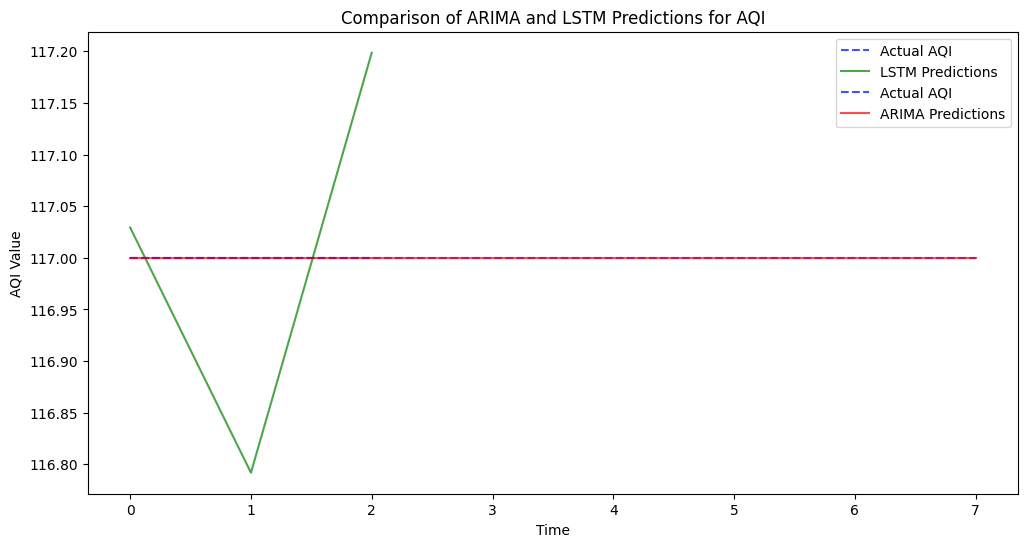

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction data from the CSV files
lstm_df = pd.read_csv('best_predictions.csv')  # LSTM predictions
arima_df = pd.read_csv('best_arima_predictions.csv')  # ARIMA predictions

# Plot the predictions from both models
plt.figure(figsize=(12, 6))

# Plot Actual vs Predicted for LSTM
plt.plot(lstm_df['Actual'], label='Actual AQI', color='blue', linestyle='--', alpha=0.7)
plt.plot(lstm_df['Predicted'], label='LSTM Predictions', color='green', linestyle='-', alpha=0.7)

# Plot Actual vs Predicted for ARIMA
plt.plot(arima_df['Actual'], label='Actual AQI', color='blue', linestyle='--', alpha=0.7)
plt.plot(arima_df['Predicted'], label='ARIMA Predictions', color='red', linestyle='-', alpha=0.7)

# Add labels and title
plt.title('Comparison of ARIMA and LSTM Predictions for AQI')
plt.xlabel('Time')
plt.ylabel('AQI Value')
plt.legend()

# Display the plot
plt.show()
